# Quantize the Ultralytics YOLOv5 model and check accuracy using the OpenVINO POT API

This tutorial demonstrates step-by-step how to perform model quantization using the OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html), compare model accuracy between the FP32 precision and quantized INT8 precision models and run a demo of model inference based on sample code from [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) with the OpenVINO backend.

First, we will export the YOLOv5m model to OpenVINO IR by following the [export instructions](https://github.com/ultralytics/yolov5/issues/251) in the [Ultralytics YOLOv5 repo](https://github.com/ultralytics/yolov5). Then we use the OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html) API to quantize the model based on the Non-Max Suppression (NMS) processing provided by Ultralytics.

OpenVINO POT provides two usages:
1. Use the API to override the model DataLoader class with custom image/annotation loading and preprocessing and identify your own class which is inherited from Metric for inference result postprocessing and accuracy calculation.
2. Use POT command line tool with the adapters provided by [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md), pre/postprocessing and metric by configuration file. This is recommend when using [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo) models with the omz_quantizer tool.

The data pre/post-processing functions provided by Ultralytics are different from the Accuracy Checker provided configuration for YOLOv3, so we will need to use the POT API (approach #1) with a custom DataLoader and Metric. This allows us to include pre- and post-processing from Ultralytics in our quantization pipeline. 


## Preparation

### Download the YOLOv5 model

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from addict import Dict 
import shutil
from IPython.display import Markdown, display

if not Path("./yolov5/").exists():
    command_download = f'{"git clone https://github.com/ultralytics/yolov5.git -b v7.0"}'
    command_download = " ".join(command_download.split())
    print("Download Ultralytics Yolov5 project source:")
    display(Markdown(f"`{command_download}`"))
    download_res = %sx $command_download
else:
    print("Ultralytics Yolov5 repo already exists.")

Ultralytics Yolov5 repo already exists.


### Conversion of the YOLOv5 model to OpenVINO

YoloV5 `export.py` scripts support multiple model formats for conversion. OpenVINO is also represented among supported formats. We need to specify `--include openvino` parameter for exporting. As the result, directory with name `yolov5m_openvino_model` will be created with following content:
* `yolov5m.yaml` - meta information for usage model with inference demo.
* `yolov5.xml`, `yolov5.bin` - OpenVINO Intermediate Representation (IR) model generated by Model Optimizer.

In [2]:
# IMAGE_SIZE = 640
# MODEL_NAME = "yolov5m"
# OPENVINO_PATH = f"yolov5/{MODEL_NAME}/{MODEL_NAME}_openvino_model"
IMAGE_SIZE = 640
MODEL_NAME = "yolov5m"
MODEL_DIR = "model"

In [3]:
%cd yolov5

/home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/yolov5


In [4]:
print("Convert PyTorch model to OpenVINO Model:")
!python export.py --weights {MODEL_DIR}/{MODEL_NAME}.pt --imgsz {IMAGE_SIZE} --batch-size 1 --include ONNX

Convert PyTorch model to OpenVINO Model:
export: data=data/coco128.yaml, weights=['model/yolov5m.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['ONNX']
YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.13 torch-1.8.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients

PyTorch: starting from model/yolov5m.pt with output shape (1, 25200, 85) (40.8 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success ✅ 3.0s, saved as model/yolov5m.onnx (81.2 MB)

Export complete (4.3s)
Results saved to /home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/yolov5/model
Detect:          python detect.py --weights model/yolov5m.onnx 
Validate:        python val.py --weights model/yolov5m.onnx 
PyTorch Hub:     model = torch.hub.

In [5]:
from openvino.tools import mo
from openvino.runtime import serialize

In [6]:
model_path = Path(MODEL_DIR) / Path(MODEL_NAME)
onnx_path = f"{model_path.with_suffix('.onnx')}"

In [7]:
output_path = Path(MODEL_DIR) / Path(MODEL_NAME + "_fp32")
out = f"{output_path.with_suffix('.xml')}"

print(f"Export ONNX to OpenVINO FP32 IR to: {out}")
model = mo.convert_model(onnx_path)
# serialize model for saving IR
serialize(model, out)

Export ONNX to OpenVINO FP32 IR to: model/yolov5m_fp32.xml


In [8]:
output_path = Path(MODEL_DIR) / Path(MODEL_NAME + "_fp16")
out = f"{output_path.with_suffix('.xml')}"

print(f"Export ONNX to OpenVINO FP16 IR to: {out}")
model = mo.convert_model(onnx_path, data_type="FP16", compress_to_fp16=True)
# serialize model for saving IR
serialize(model, out)

[ WARNING ]  Use of deprecated cli option --data_type detected. Option use in the following releases will be fatal. 


Export ONNX to OpenVINO FP16 IR to: model/yolov5m_fp16.xml


### Change COCO dataset path

In [10]:
!sed -i 's#../datasets/coco#../coco#g' ./data/coco.yaml
!cat ./data/coco.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO 2017 dataset http://cocodataset.org by Microsoft
# Example usage: python train.py --data coco.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco  ← downloads here (20.1 GB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../coco  # dataset root dir
train: train2017.txt  # train images (relative to 'path') 118287 images
val: val2017.txt  # val images (relative to 'path') 5000 images
test: test-dev2017.txt  # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handb

### Imports

In [10]:
# sys.path.append(".")
# import yolov5 module
from utils.dataloaders import create_dataloader
from utils.general import check_dataset, non_max_suppression, scale_boxes, xywh2xyxy, check_yaml,increment_path
from utils.metrics import ap_per_class
from val import process_batch

from openvino.tools.pot.api import Metric, DataLoader
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.tools.pot.utils.logger import init_logger, get_logger

/home/ease/miniconda3/envs/openvino/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


## Model Quantization with POT
### Create YOLOv5 DataLoader class

Create a class for the loading YOLOv5 dataset and annotation which inherits from POT API class DataLoader. The Ultralytics YOLOv5 training process requires image data normalization from [0,225] 8-bit integer range to [0.0,1.0] 32-bit floating point range.

In [11]:
class YOLOv5DataLoader(DataLoader):
    """ Inherit from DataLoader function and implement for YOLOv5.
    """

    def __init__(self, config):
        if not isinstance(config, Dict):
            config = Dict(config)
        super().__init__(config)

        self._data_source = config.data_source
        self._imgsz = config.imgsz
        self._batch_size = 1
        self._stride = 32
        self._single_cls = config.single_cls
        self._pad = 0.5
        self._rect = False
        self._workers = 1
        self._data_loader = self._init_dataloader()
        self._data_iter = iter(self._data_loader)

    def __len__(self):
        return len(self._data_loader.dataset)

    def _init_dataloader(self):
        dataloader = create_dataloader(self._data_source['val'], imgsz=self._imgsz, batch_size=self._batch_size, stride=self._stride,
                                       single_cls=self._single_cls, pad=self._pad, rect=self._rect, workers=self._workers)[0]
        return dataloader

    def __getitem__(self, item):
        try:
            batch_data = next(self._data_iter)
        except StopIteration:
            self._data_iter = iter(self._data_loader)
            batch_data = next(self._data_iter)

        im, target, path, shape = batch_data

        im = im.float()  
        im /= 255  
        nb, _, height, width = im.shape  
        img = im.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        annotation = dict()
        annotation['image_path'] = path
        annotation['target'] = target
        annotation['batch_size'] = nb
        annotation['shape'] = shape
        annotation['width'] = width
        annotation['height'] = height
        annotation['img'] = img

        return (item, annotation), img

### Create YOLOv5 Metric Class

Create a class to measure the model performance by Mean Average Precision (mAP) with the COCO dataset predicted result and annotation value, after applying Ultralytics NMS routine (`yolov5.utils.general.non_max_suppression`). Here we use both AP\@0.5 and AP\@0.5:0.95 as the measurement standard. This class should be inherited from the POT API Metric class.

The COCOMetric.update() function contains post-processing with Non-Max Suppression to sort boxes by score and select the box with the highest score.

In [12]:
class COCOMetric(Metric):
    """ Inherit from DataLoader function and implement for YOLOv5.
    """

    def __init__(self, config):
        super().__init__()
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._names = (*self._metric_dict,)
        self._stats = []
        self._last_stats = []
        self._conf_thres = config.conf_thres
        self._iou_thres = config.iou_thres
        self._single_cls = config.single_cls
        self._nc = config.nc
        self._class_names = {idx:name for idx,name in enumerate(config.names)}
        self._device = config.device

    @property
    def value(self):
        """ Returns metric value for the last model output.
        Both use AP@0.5 and AP@0.5:0.95
        
        The value() property should be implemented to use this metric '
                        'with AccuracyAwareQuantization algorithm!
        """
        mp, mr, map50, map = self._process_stats(self._last_stats)
        return {self._names[0]: [map50], self._names[1]: [map]}

    @property
    def avg_value(self):
        """ Returns metric value for all model outputs.
        Both use AP@0.5 and AP@0.5:0.95
        """
        mp, mr, map50, map = self._process_stats(self._stats)

        return {self._names[0]: map50, self._names[1]: map}

    def _process_stats(self, stats):
        mp, mr, map50, map = 0.0, 0.0, 0.0, 0.0
        # stats = [np.concatenate(x, 0).cpu().numpy() for x in zip(*stats)]
        stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]
        
        if len(stats) and stats[0].any():
            # tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=True, save_dir=None, names=self._class_names)
            tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=True, names=self._class_names)
            ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
            mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
            # np.bincount(stats[3].astype(np.int64), minlength=self._nc)
        # else:
            # torch.zeros(1)

        return mp, mr, map50, map

    def update(self, output, target):
        """ Calculates and updates metric value
        Contains postprocessing part from Ultralytics YOLOv5 project
        :param output: model output
        :param target: annotations
        """

        annotation = target[0]["target"]
        width = target[0]["width"]
        height = target[0]["height"]
        shapes = target[0]["shape"]
        paths = target[0]["image_path"]
        im = target[0]["img"]

        iouv = torch.linspace(0.5, 0.95, 10).to(self._device)  # iou vector for mAP@0.5:0.95
        niou = iouv.numel()
        seen = 0
        stats = []
        # NMS
        annotation = torch.Tensor(annotation)
        # annotation[:, 2:] *= torch.Tensor([width, height, width, height]).to(self._device)  # to pixels
        annotation[:, 2:] *= torch.tensor((width, height, width, height), device=self._device)  # to pixels

        lb = []
        out = output[0]
        out = torch.Tensor(out).to(self._device)
        out = non_max_suppression(out, self._conf_thres, self._iou_thres, labels=lb,
                                  multi_label=True, agnostic=self._single_cls)
        # Metrics
        for si, pred in enumerate(out):
            labels = annotation[annotation[:, 0] == si, 1:]
            # nl = len(labels)
            nl, npr = labels.shape[0], pred.shape[0] # number of labels, predictions
            # tcls = labels[:, 0].tolist() if nl else []  # target class
            _, shape = Path(paths[si]), shapes[si][0]
            correct = torch.zeros(npr, niou, dtype=torch.bool, device=self._device)  # init
            seen += 1

            if npr == 0:
                if nl:
                    # stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                    stats.append((correct, *torch.zeros((2, 0), device=self._device), labels[:, 0]))
                continue

            # Predictions
            if self._single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_boxes(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_boxes(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            # else:
            #     correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), labels[:,0]))
            self._stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), labels[:,0]))
        self._last_stats = stats

    def reset(self):
        """ Resets metric """
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._last_stats = []
        self._stats = []

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                                                 'type': metric type
        """
        return {self._names[0]: {'direction': 'higher-better',
                                 'type': 'AP@0.5'},
                self._names[1]: {'direction': 'higher-better',
                                 'type': 'AP@0.5:0.95'}}

### Set POT Configuration

Create a function to set the configuration of the model, engine, dataset, metric and algorithms, which are used by the POT quantization pipeline API.

Here we use "DefaultQuantization" method for best performance of the quantization step. Alternatively, the "AccuracyAwareQuantization" method can be used to keep accuracy loss below a predefined threshold, at the cost of performance during the quantization process (it takes longer to quantize the model). This is useful when DefaultQuantization results in more accuracy loss than desired.

In [13]:
def get_config():
    """ Set the configuration of the model, engine, 
    dataset, metric and quantization algorithm.
    """
    config = dict()
    data_yaml = check_yaml("./data/coco.yaml")
    data = check_dataset(data_yaml)

    model_fp32_config = Dict({
        "model_name": f"{MODEL_NAME}_fp32",
        "model": f"{MODEL_DIR}/{MODEL_NAME}_fp32.xml",
        "weights": f"{MODEL_DIR}/{MODEL_NAME}_fp32.bin"
    })

    model_fp16_config = Dict({
        "model_name": f"{MODEL_NAME}_fp16",
        "model": f"{MODEL_DIR}/{MODEL_NAME}_fp16.xml",
        "weights": f"{MODEL_DIR}/{MODEL_NAME}_fp16.bin"
    })

    model_int8_config = Dict({
        "model_name" : f"{MODEL_NAME}_int8", 
        "save_path": MODEL_DIR
    })

    engine_config = Dict({
        "device": "CPU",
        # "device": "GPU",
        "stat_requests_number": 8,
        "eval_requests_number": 8
    })

    dataset_config = Dict({
        "data_source": data,
        "imgsz": 640,
        "single_cls": False,
    })

    metric_config = Dict({
        "conf_thres": 0.001,
        "iou_thres": 0.65,
        "single_cls": False,
        "nc": 1 ,  # if opt.single_cls else int(data['nc']),
        "names": data["names"],
        "device": "cpu"
    })

    algorithms = [
        {
            "name": "DefaultQuantization",  # or AccuracyAwareQuantization
            "params": {
                    "target_device": "CPU",
                    "preset": "mixed",
                    "stat_subset_size": 300
            }
        }
    ]

    config["model_fp32"] = model_fp32_config
    config["model_fp16"] = model_fp16_config
    config["model_int8"] = model_int8_config
    
    config["engine"] = engine_config
    config["dataset"] = dataset_config
    config["metric"] = metric_config
    config["algorithms"] = algorithms
    
    return config

### Run Quantization Pipeline and Accuracy Verification

The following 9 steps show how to quantize the model using the POT API. The optimized model and collected min-max values will be saved. 

It will take few minutes for generating FP32-INT8 model, please check the quantized model is successfully saved and you get the metric results of INT8 model before running on next cell.

In [14]:
coco_cache = "./coco/val2017.cache"
if os.path.exists(coco_cache):
    os.remove(coco_cache)

In [15]:
print("Run the POT. This will take few minutes...")
config = get_config()  
init_logger(level='INFO')
logger = get_logger(__name__)

# Step 1: Initialize the data loader.
data_loader = YOLOv5DataLoader(config["dataset"])

# Step 2 (Optional. Required for AccuracyAwareQuantization): Initialize the metric.
metric = COCOMetric(config["metric"])

# Step 3: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=config["engine"], data_loader=data_loader, metric=metric)

# Step 4: Create a pipeline of compression algorithms.
pipeline = create_pipeline(config["algorithms"], engine)

# metric_results = None

Run the POT. This will take few minutes...


Scanning /home/ease/repos/my_openvino_notebooks/notebooks/yolov5v7/coco/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 00:00


In [16]:
config["model_fp16"]

{'model_name': 'yolov5m_fp16',
 'model': 'model/yolov5m_fp16.xml',
 'weights': 'model/yolov5m_fp16.bin'}

In [17]:
# Step 5: Load the model.
model = load_model(config["model_fp16"])

# Check the FP16 model accuracy.
metric_results_fp16 = pipeline.evaluate(model)

logger.info("FP16 model metric_results: {}".format(metric_results_fp16))

INFO:openvino.tools.pot.pipeline.pipeline:Evaluation of generated model
INFO:openvino.tools.pot.engines.ie_engine:Start inference of 5000 images
INFO:openvino.tools.pot.engines.ie_engine:500/5000 batches are processed in 91.53s
INFO:openvino.tools.pot.engines.ie_engine:1000/5000 batches are processed in 181.20s
INFO:openvino.tools.pot.engines.ie_engine:1500/5000 batches are processed in 271.92s
INFO:openvino.tools.pot.engines.ie_engine:2000/5000 batches are processed in 361.92s
INFO:openvino.tools.pot.engines.ie_engine:2500/5000 batches are processed in 451.76s
INFO:openvino.tools.pot.engines.ie_engine:3000/5000 batches are processed in 541.60s


WARNING ⚠️ NMS time limit 0.550s exceeded


INFO:openvino.tools.pot.engines.ie_engine:3500/5000 batches are processed in 633.07s


WARNING ⚠️ NMS time limit 0.550s exceeded


INFO:openvino.tools.pot.engines.ie_engine:4000/5000 batches are processed in 724.57s
INFO:openvino.tools.pot.engines.ie_engine:4500/5000 batches are processed in 813.98s
INFO:openvino.tools.pot.engines.ie_engine:5000/5000 batches are processed in 903.69s
INFO:openvino.tools.pot.engines.ie_engine:Inference finished
INFO:__main__:FP16 model metric_results: {'AP@0.5': 0.6325177351096942, 'AP@0.5:0.95': 0.44795891201229754}


In [18]:
# Step 5: Load the model.
model_fp32 = load_model(config["model_fp32"])

# Check the FP32 model accuracy.
metric_results_fp32 = pipeline.evaluate(model_fp32)

logger.info("FP32 model metric_results: {}".format(metric_results_fp32))

INFO:openvino.tools.pot.pipeline.pipeline:Evaluation of generated model
INFO:openvino.tools.pot.engines.ie_engine:Start inference of 5000 images
INFO:openvino.tools.pot.engines.ie_engine:500/5000 batches are processed in 91.29s
INFO:openvino.tools.pot.engines.ie_engine:1000/5000 batches are processed in 181.72s
INFO:openvino.tools.pot.engines.ie_engine:1500/5000 batches are processed in 272.00s
INFO:openvino.tools.pot.engines.ie_engine:2000/5000 batches are processed in 362.40s
INFO:openvino.tools.pot.engines.ie_engine:2500/5000 batches are processed in 452.63s
INFO:openvino.tools.pot.engines.ie_engine:3000/5000 batches are processed in 542.62s


WARNING ⚠️ NMS time limit 0.550s exceeded


INFO:openvino.tools.pot.engines.ie_engine:3500/5000 batches are processed in 633.07s


WARNING ⚠️ NMS time limit 0.550s exceeded


INFO:openvino.tools.pot.engines.ie_engine:4000/5000 batches are processed in 723.02s
INFO:openvino.tools.pot.engines.ie_engine:4500/5000 batches are processed in 813.12s
INFO:openvino.tools.pot.engines.ie_engine:5000/5000 batches are processed in 903.03s
INFO:openvino.tools.pot.engines.ie_engine:Inference finished
INFO:__main__:FP32 model metric_results: {'AP@0.5': 0.6325203891388412, 'AP@0.5:0.95': 0.4479408093872939}


In [19]:
# Step 6: Execute the pipeline to calculate Min-Max value
compressed_model = pipeline.run(model)

# Step 7 (Optional):  Compress model weights to quantized precision
#                     in order to reduce the size of final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
optimized_save_dir = Path(Path.cwd()).joinpath(config["model_int8"]["save_path"])
save_model(compressed_model, optimized_save_dir, config["model_int8"]["model_name"])

# Step 9 (Optional): Evaluate the compressed model. Print the results.
metric_results_i8 = pipeline.evaluate(compressed_model)

logger.info("Save quantized model in {}".format(optimized_save_dir))
logger.info("Quantized INT8 model metric_results: {}".format(metric_results_i8))

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-8831-4f0b846d1a5
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection
INFO:openvino.tools.pot.algori

Compare Average Precision of quantized INT8 model with FP32 original model. 

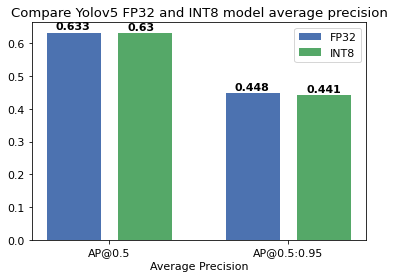

In [8]:
%matplotlib inline
plt.style.use('seaborn-deep')
fp32_acc = np.array(list(metric_results_fp32.values()))
int8_acc = np.array(list(metric_results_i8.values()))
x_data = ("AP@0.5","AP@0.5:0.95")
x_axis = np.arange(len(x_data))
fig = plt.figure()
fig.patch.set_facecolor('#FFFFFF')
fig.patch.set_alpha(0.7)
ax = fig.add_subplot(111)
plt.bar(x_axis - 0.2, fp32_acc, 0.3, label='FP32')
for i in range(0, len(x_axis)):
    plt.text(i - 0.3, round(fp32_acc[i],3) + 0.01, str(round(fp32_acc[i],3)),fontweight="bold")
plt.bar(x_axis + 0.2, int8_acc, 0.3, label='INT8')
for i in range(0, len(x_axis)):
    plt.text(i + 0.1, round(int8_acc[i],3) + 0.01, str(round(int8_acc[i],3)),fontweight="bold")
plt.xticks(x_axis, x_data)
plt.xlabel("Average Precision")
plt.title("Compare Yolov5 FP32 and INT8 model average precision")

plt.legend()
plt.show()

# Benchmark

In [12]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp32.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 57.22 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [5]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp16.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 37.72 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [6]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_int8.xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 36.05 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [7]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp32.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 54.73 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [11]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_fp16.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 38.03 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


In [9]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m {MODEL_DIR}/{MODEL_NAME}_int8.xml -d GPU -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2022.3.0-8831-4f0b846d1a5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 40.49 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the model
[ INFO ] Model inputs:


## Inference Demo Performance Comparison

This part shows how to use the Ultralytics model detection code ["detect.py"](https://github.com/ultralytics/yolov5/blob/master/detect.py) to run synchronous inference using the OpenVINO Python API on 2 images.

In [9]:
# copy original model metadata to optimikzed model directory
import shutil

metafile = optimized_save_dir / "yolov5m_int8.yaml"
if not metafile.exists():
    shutil.copyfile('./yolov5/model/yolov5m_int8.yaml', metafile)
command_detect = "cd yolov5 && python detect.py --weights ./model/yolov5m_int8"
display(Markdown(f"`{command_detect}`"))
%sx $command_detect

`cd yolov5 && python detect.py --weights ./yolov5m/optimized/yolov5m_openvino_model`

["\x1b\x1bdetect: \x1bweights=['./yolov5m/optimized/yolov5m_openvino_model'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1",
 'YOLOv5 🚀 v7.0-0-g915bbf2 Python-3.8.13 torch-1.8.1+cpu CPU',
 '',
 'Loading yolov5m/optimized/yolov5m_openvino_model for OpenVINO inference...',
 'image 1/2 /home/ease/repos/openvino_notebooks/notebooks/220-yolov5-accuracy-check-and-quantization/yolov5/data/images/bus.jpg: 640x640 4 persons, 1 bus, 60.3ms',
 'image 2/2 /home/ease/repos/openvino_notebooks/notebooks/220-yolov5-accuracy-check-and-quantization/yolov5/data/images/zidane.jpg: 640x640 3 persons, 2 ties, 52.7ms',
 'Speed: 0.7ms pre-process

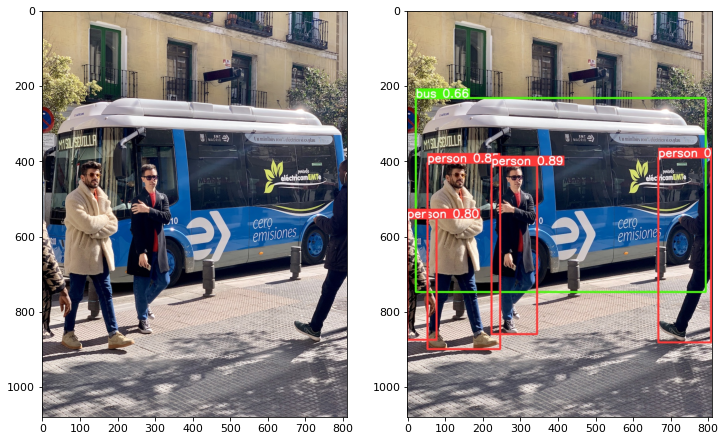

: 

In [10]:
%matplotlib inline
import matplotlib.image as mpimg
fig2 = plt.figure(figsize=(12, 9))
fig2.patch.set_facecolor('#FFFFFF')
fig2.patch.set_alpha(0.7)
axarr1 = fig2.add_subplot(121)
axarr2 = fig2.add_subplot(122)
ori = mpimg.imread('./yolov5/data/images/bus.jpg')
result = mpimg.imread('./yolov5/runs/detect/exp/bus.jpg')
_ = axarr1.imshow(ori)
_ = axarr2.imshow(result)

## References

* [Ultralytics YOLOv5](https://github.com/ultralytics/yolov5)
* [OpenVINO Post-training Optimization Tool](https://docs.openvino.ai/latest/pot_introduction.html)
* [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo)
* [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md)
